In [16]:
from scipy import optimize as opt
import numpy as np
from math import exp, log
import matplotlib.pyplot as plt
import scipy.stats as st
import openmc.deplete
import pandas as pd

Mean of  Xe135 : 8.947E+13  at/cc
Std Dev of  Xe135 : 1.362E+14  at/cc
Min of  Xe135 : 7.277E-01  at/cc
Max of  Xe135 : 3.254E+14  at/cc
Min of Removal Coeff.:  0.000E+00  s-1
Pearson r coeff:  PearsonRResult(statistic=nan, pvalue=nan)
Spearman coeff:  SignificanceResult(statistic=nan, pvalue=nan)
Kendalls tau coeff:  SignificanceResult(statistic=nan, pvalue=nan)
Nuclide | Half-Life (s) | Fission Yields
Sb135  | 1.679E+00     | 1.458E-03
Te135  | 1.900E+01     | 3.216E-02
I135  | 2.365E+04     | 2.927E-02
Xe135_m1  | 9.174E+02     | 1.102E-02
Xe135  | 3.290E+04     | 7.851E-04
Direct Production of  Sb135 : 4.378E+08  at/cc
Direct Production of  Te135 : 1.093E+11  at/cc
Direct Production of  I135 : 1.239E+14  at/cc
Direct Production of  Xe135_m1 : 1.808E+12  at/cc
Direct Production of  Xe135 : 4.622E+12  at/cc
Cumulative Production of  Sb135 : 4.378E+08  at/cc
Cumulative Production of  Te135 : 1.143E+11  at/cc
Cumulative Production of  I135 : 2.661E+14  at/cc
Cumulative Production of  X

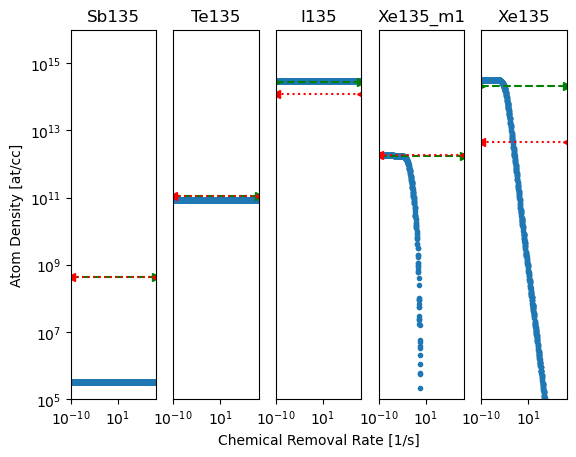

In [20]:
# #
# # USER INPUTS
# #

# Pick which isobar you want to model:
decay_chain_isobar = 135
reactor_name = "MSRE"


# # Reactor parameters: Flowpath, region, power
if reactor_name == "MSRE":
    # volumetric flow rates for each flowpath [cm3/s]
    nu1 = 66666.6667      # excore to core
    nu2 = 66666.6667      # core to excore
    # residence times in each region [s]
    t1 = 9.9              # core
    t2 = 20.1             # excore
    # volume in each region [cm3]
    V1 = 660000           # core
    V2 = 1340000          # excore
    # power [W] and flux [n/cm2-s]
    P_mu = 8000000        # 8 MWth
    P_sigma = 0           # if you want to do Monte Carlo on power level
    phi_th = 6E12 
elif reactor_name == "MSDR":
    # volumetric flow rates for each flowpath [cm3/s]
    nu1 = 2.0655E+06      # excore to core
    nu2 = 2.0655E+06      # core to excore
    # residence times in each region [s]
    t1 = 14               # core
    t2 = 6                # excore
    # volume in each region [cm3]
    V1 = 2.89170E+07      # core
    V2 = 1.23930E+07      # excore
    P_mu = 750000000      # 750 MWth
    P_sigma = 0           # if you want to do Monte Carlo on power level
    phi_th = 1.8E13 
else:
  print('Chosen reactor is not available!') 

nui = np.array([nu1, nu2])
Vi = np.array([V1, V2])

# "Power constant" (PC):
PC_mu = 31000000000       # Default: 31000000000
PC_sigma = 0              # if you want to do Monte Carlo on power level constant

# Add Thermal Microscopic Cross Sections [cm2] to nuclear data
ng_Nb95 = 7.0470486E-24
ng_Nb95_m1 = 2.49332E-24
ng_I131 = 80.536095E-24
ng_I135 = 80.53724E-24
ng_Xe135 = 2666886.8E-24
ng_Xe135_m1 = 0 #10187238E-24
ng_Ce141 = 29.19615E-24
ng_Nd147 = 443.4743E-24
ng_Eu155 = 3783.1646E-24

# Number of histories for the Monte Carlo Sampling of each isobar:
MCSiter = 1000

# fission products generated per second, FY [atoms/s], as a result of fissions in the core at power level, P [W]
frac233 = frac235 = frac239 = 0
# frac233 = 0.935
# frac233 = 1
# frac235 = 0.022
frac235 = 1
# frac239 = 0.043
# frac239 = 1

# Spray Ring Chemical Removal Rates
spray_ring_chemical_removal_NbMoTcRu = 0
spray_ring_chemical_removal_noblemetal = 0
spray_ring_chemical_removal_Sn = 0
spray_ring_chemical_removal_Sb = 0
spray_ring_chemical_removal_Te = 0
spray_ring_chemical_removal_halogen = 0
spray_ring_chemical_removal_noblegas = 0 # 0.0041 / 0.08212
spray_ring_chemical_removal_alkali = 0
spray_ring_chemical_removal_alkalineearth = 0
spray_ring_chemical_removal_rareearth = 0

# Alloy Deposition Chemical Removal Rates
deposition_chemical_removal_NbMoTcRu = 0
deposition_chemical_removal_noblemetal = 0
deposition_chemical_removal_Sn = 0
deposition_chemical_removal_Sb = 0
deposition_chemical_removal_Te = 0

# Density of fuel salt [g/cm3]
rho_mu = 2.32
rho_sigma = 0.0

# Pick Solver Method: Should be one of - 'hybr' , 'lm' , 'broyden1' , 'broyden2' , 'anderson' , 'linearmixing' ,
# 'diagbroyden' , 'excitingmixing' , 'krylov' , 'df-sane'
solver_method = 'hybr'

# Initiate chemical removal constant in region 2: spray into the pump bowl pool, deposition on piping in Leg A, Leg B/HX
r_2a = r_2b = r_2c = r_2d = 0.0
# Initiate chemical removal constant in regions 1: core
r_1a = r_1b = r_1c = r_1d = 0.0

# Initiate Decay Branching Ratios
br_c_d = 1
br_dm1_d = 1


# #
# # LOAD NUCLEAR DATA FROM OPENMC
# #


# Read decay constants from OpenMC depletion chain
chain = openmc.deplete.Chain.from_xml('chain_endfb71.xml')
lam = {}
for nuclide in chain.nuclides:
   if nuclide.half_life is not None:
      lam[nuclide.name] = log(2.0) / nuclide.half_life

# Read fission product yields from OpenMC database
Y_cumulative = {}
Y_independent = {}
u233 = openmc.data.FissionProductYields('fission_yields/nfy-092_U_233.endf')
u235 = openmc.data.FissionProductYields('fission_yields/nfy-092_U_235.endf')
pu239 = openmc.data.FissionProductYields('fission_yields/nfy-094_Pu_239.endf')

for nuclide in u233.cumulative[0]:
   # Skip nuclides that don't appear for all sets of FPYs
   if nuclide not in u235.cumulative[0] or nuclide not in pu239.cumulative[0]:
      continue

   Y_cumulative[nuclide] = (
      u233.cumulative[0][nuclide].nominal_value * frac233 +
      u235.cumulative[0][nuclide].nominal_value * frac235 +
      pu239.cumulative[0][nuclide].nominal_value * frac239
   )
   Y_independent[nuclide] = (
      u233.independent[0][nuclide].nominal_value * frac233 +
      u235.independent[0][nuclide].nominal_value * frac235 +
      pu239.independent[0][nuclide].nominal_value * frac239
   )



# #
# # MONTE CARLO SAMPLING
# #


power_min, power_max = -10, 10
# V1_lower, V1_upper = 0.0, 3000000
# V1_rvs = st.truncnorm(
#    (V1_lower - V1_mu) / V1_sigma, (V1_upper - V1_mu) / V1_sigma, loc=V1_mu, scale=V1_sigma)
# V1_dist = V1_rvs.rvs(1000)
list_rho = []
list_P = []
list_PC = []
list_noblegas_SP = []
list_NbMoTcRu_SP = []
list_Sn_dep = []
list_Sb_dep = []
list_Te_dep = []
list_NbMoTcRu_dep = []
list_dpmga_1 = []
list_dpmgb_1 = []
list_dpmgc_1 = []
list_dpmgd_m1_1 = []
list_dpmgd_1 = []
list_dpmga_0 = []
list_dpmgb_0 = []
list_dpmgc_0 = []
list_dpmgd_m1_0 = []
list_dpmgd_0 = []
list_atcca_1 = []
list_atccb_1 = []
list_atccc_1 = []
list_atccd_m1_1 = []
list_atccd_1 = []
list_atcca_0 = []
list_atccb_0 = []
list_atccc_0 = []
list_atccd_m1_0 = []
list_atccd_0 = []
log_array = np.logspace(-10, 10, 1000, base=10)
power_linear_array = np.linspace(0, P_mu, 1000)
for i in range(MCSiter):
    rho = np.random.normal(rho_mu, rho_sigma)
    P = np.random.normal(P_mu, P_sigma)
#     P = power_linear_array[i]                                        # use to perturb power level from 0 to 8 MW
#     P = np.random.choice(power_linear_array)
#     P = shuffled_array[i]
    PC = np.random.normal(PC_mu, PC_sigma)
    random_power = np.random.uniform(power_min, power_max)
    spray_ring_chemical_removal_noblegas = 10 ** random_power
#     spray_ring_chemical_removal_NbMoTcRu = 10 ** random_power
#     spray_ring_chemical_removal_NbMoTcRu = log_array[i]              # use to perturb spray ring removal
    # deposition_chemical_removal_Sn = 10 ** random_power
    # deposition_chemical_removal_Sb = 10 ** random_power
    # deposition_chemical_removal_Te = 10 ** random_power
#     deposition_chemical_removal_NbMoTcRu = 10 ** random_power
#     deposition_chemical_removal_NbMoTcRu = log_array[i]


    list_rho.append(rho)
    list_P.append(P)
    list_PC.append(PC)
    list_noblegas_SP.append(spray_ring_chemical_removal_noblegas)
    list_NbMoTcRu_SP.append(spray_ring_chemical_removal_NbMoTcRu)
    list_Sn_dep.append(deposition_chemical_removal_Sn)
    list_Sb_dep.append(deposition_chemical_removal_Sb)
    list_Te_dep.append(deposition_chemical_removal_Te)
    list_NbMoTcRu_dep.append(deposition_chemical_removal_NbMoTcRu)


    # TODO: Account for metastable/ground yields when they are being grouped
    # together. Right now they are being added manually

    # #
    # # LOAD VARIABLES BASED ON CHOSEN ISOBAR
    # #


    if decay_chain_isobar == 89:
      isotopea = 'Br89'
      isotopeb = 'Kr89'
      isotopec = 'Rb89'
      isotoped = 'Sr89'
      r_2a = spray_ring_chemical_removal_halogen
      r_2b = spray_ring_chemical_removal_noblegas
      r_2c = spray_ring_chemical_removal_alkali
      r_2d = spray_ring_chemical_removal_alkalineearth
    elif decay_chain_isobar == 90:
      isotopea = 'Br90'
      isotopeb = 'Kr90'
      isotopec = 'Rb90'
      isotoped = 'Sr90'
      r_2a = spray_ring_chemical_removal_halogen
      r_2b = spray_ring_chemical_removal_noblegas
      r_2c = spray_ring_chemical_removal_alkali
      r_2d = spray_ring_chemical_removal_alkalineearth
    elif decay_chain_isobar == 91:
      isotopea = 'Kr91'
      isotopeb = 'Rb91'
      isotopec = 'Sr91'
      isotoped = 'Y91'
      r_2a = spray_ring_chemical_removal_noblegas
      r_2b = spray_ring_chemical_removal_alkali
      r_2c = spray_ring_chemical_removal_alkalineearth
      r_2d = spray_ring_chemical_removal_rareearth
    elif decay_chain_isobar == 95:
      isotopea = 'Sr95'
      isotopeb = 'Y95'
      isotopec = 'Zr95'
      isotoped_m1 = 'Nb95_m1'
      isotoped = 'Nb95'
      r_2a = spray_ring_chemical_removal_alkalineearth
      r_2b = spray_ring_chemical_removal_rareearth
      r_2d = spray_ring_chemical_removal_NbMoTcRu
      r_2d = deposition_chemical_removal_NbMoTcRu
      r_1d = ng_Nb95
      r_1d_m1 = ng_Nb95_m1
      br_c_d = 0.9891978
      br_dm1_d = 0.944
    elif decay_chain_isobar == 97:
      isotopea = 'Sr97'
      isotopeb = 'Y97'
      isotopec = 'Zr97'
      isotoped_m1 = 'Nb97_m1'
      isotoped = 'Nb97'
      r_2a = spray_ring_chemical_removal_alkalineearth
      r_2b = spray_ring_chemical_removal_rareearth
      r_2d = spray_ring_chemical_removal_NbMoTcRu
      r_2d = deposition_chemical_removal_NbMoTcRu
      br_c_d = 0.0495367
      br_dm1_d = 1
    elif decay_chain_isobar == 99:
      isotopea = 'Y99'
      isotopeb = 'Zr99'
      isotopec = 'Nb99'
      isotoped = 'Mo99'
      r_2a = r_2b = spray_ring_chemical_removal_rareearth
      r_2c = r_2d = spray_ring_chemical_removal_NbMoTcRu + deposition_chemical_removal_NbMoTcRu
    elif decay_chain_isobar == 103:
      isotopea = 'Nb103'
      isotopeb = 'Mo103'
      isotopec = 'Tc103'
      isotoped = 'Ru103'
      r_2a = r_2b = r_2c = r_2d = spray_ring_chemical_removal_NbMoTcRu + deposition_chemical_removal_NbMoTcRu
    elif decay_chain_isobar == 106:
      isotopea = 'Mo106'
      isotopeb = 'Tc106'
      isotopec = 'Ru106'
      isotoped = 'Rh106'
      r_2a = r_2b = r_2c = spray_ring_chemical_removal_NbMoTcRu + deposition_chemical_removal_NbMoTcRu
      r_2d = spray_ring_chemical_removal_noblemetal
    elif decay_chain_isobar == 111:
      isotopea = 'Rh111'
      isotopeb = 'Pd111_m1'
      isotopec = 'Pd111'
      isotoped = 'Ag111'
      r_2a = r_2b = r_2c = r_2d = spray_ring_chemical_removal_noblemetal + deposition_chemical_removal_noblemetal
    elif decay_chain_isobar == 129:
      isotopea = 'Sn129_m1'
      isotopeb = 'Sb129'
      isotopec = 'Te129_m1'
      isotoped = 'Te129'
      r_2a = spray_ring_chemical_removal_Sn + deposition_chemical_removal_Sn
      r_2b = spray_ring_chemical_removal_Sb + deposition_chemical_removal_Sb
      r_2c = r_2d = spray_ring_chemical_removal_Te + deposition_chemical_removal_Te
    elif decay_chain_isobar == 131:
      isotopea = 'Sn131'
      isotopeb = 'Sb131'
      isotopec = 'Te131_m1'
      isotoped = 'I131'
      r_2a = spray_ring_chemical_removal_Sn + deposition_chemical_removal_Sn
      r_2b = spray_ring_chemical_removal_Sb + deposition_chemical_removal_Sb
      r_2c = spray_ring_chemical_removal_Te + deposition_chemical_removal_Te
      r_2d = spray_ring_chemical_removal_halogen
      r_1d = phi_th * ng_I131  
    elif decay_chain_isobar == 132:
      isotopea = 'Sn132'
      isotopeb = 'Sb132'
      isotopec = 'Te132'
      isotoped = 'I132'
      r_2a = spray_ring_chemical_removal_Sn + deposition_chemical_removal_Sn
      r_2b = spray_ring_chemical_removal_Sb + deposition_chemical_removal_Sb
      r_2c = spray_ring_chemical_removal_Te + deposition_chemical_removal_Te
      r_2d = spray_ring_chemical_removal_halogen
    elif decay_chain_isobar == 135:
      isotopea = 'Sb135'
      isotopeb = 'Te135'
      isotopec = 'I135'
      isotoped_m1 = 'Xe135_m1'
      isotoped = 'Xe135'
      r_2a = spray_ring_chemical_removal_Sb + deposition_chemical_removal_Sb
      r_2b = spray_ring_chemical_removal_Te + deposition_chemical_removal_Te
      r_2c = spray_ring_chemical_removal_halogen
      r_2d = spray_ring_chemical_removal_noblegas
      r_1c = phi_th * ng_I135
      r_1d = phi_th * ng_Xe135
      r_1d_m1 = phi_th * ng_Xe135_m1
      br_c_d = 0.8349109
      br_dm1_d = 0.997
    elif decay_chain_isobar == 137:
      isotopea = 'Te137'
      isotopeb = 'I137'
      isotopec = 'Xe137'
      isotoped = 'Cs137'
      r_2a = spray_ring_chemical_removal_Te + deposition_chemical_removal_Te
      r_2b = spray_ring_chemical_removal_halogen
      r_2c = spray_ring_chemical_removal_noblegas
      r_2d = spray_ring_chemical_removal_alkali
    elif decay_chain_isobar == 140:
      isotopea = 'Xe140'
      isotopeb = 'Cs140'
      isotopec = 'Ba140'
      isotoped = 'La140'
      r_2a = spray_ring_chemical_removal_noblegas
      r_2b = spray_ring_chemical_removal_alkali
      r_2c = spray_ring_chemical_removal_alkalineearth
      r_2d = spray_ring_chemical_removal_rareearth
    elif decay_chain_isobar == 141:
      isotopea = 'Cs141'
      isotopeb = 'Ba141'
      isotopec = 'La141'
      isotoped = 'Ce141'
      r_2a = spray_ring_chemical_removal_alkali
      r_2b = spray_ring_chemical_removal_alkalineearth
      r_2c = r_6d = spray_ring_chemical_removal_rareearth
      r_1d = phi_th * ng_Ce141
    elif decay_chain_isobar == 144:
      isotopea = 'Ba144'
      isotopeb = 'La144'
      isotopec = 'Ce144'
      isotoped = 'Pr144'
      r_2a = spray_ring_chemical_removal_alkalineearth
      r_2b = r_2c = r_2d = spray_ring_chemical_removal_rareearth
    elif decay_chain_isobar == 147:
      isotopea = 'La147'
      isotopeb = 'Ce147'
      isotopec = 'Pr147'
      isotoped = 'Nd147'
      r_2a = r_2b = r_2c = r_2d = spray_ring_chemical_removal_rareearth
      r_1d = phi_th * ng_Nd147 
    elif decay_chain_isobar == 155:
      isotopea = 'Nd155'
      isotopeb = 'Pm155'
      isotopec = 'Sm155'
      isotoped = 'Eu155'
      r_2a = r_2b = r_2c = r_2d = spray_ring_chemical_removal_rareearth
      r_1d = phi_th * ng_Eu155
    else:
      print('Chosen decay chain isobar is not available!')    

    # # Decay Chain Parameters
    # decay constant for each nuclide in the decay chain [s-1]

    lama = lam[isotopea]
    lamb = lam[isotopeb]
    lamc = lam[isotopec]
    lamd_m1 = lam[isotoped_m1]
    lamd = lam[isotoped]

    Ya = Y_cumulative[isotopea]
    Yb = Y_independent[isotopeb]
    Yc = Y_independent[isotopec]
    Yd_m1 = Y_cumulative[isotoped_m1]
    Yd = Y_independent[isotoped]

    FYa = PC * P * Ya   # atoms/s = fissions/J * J/s * yield_fraction
    FYb = PC * P * Yb
    FYc = PC * P * Yc
    FYd_m1 = PC * P * Yd_m1
    FYd = PC * P * Yd

    # # # Decay Chain: Isotope A
    # source term in each region [atoms/cm3/s]

    S = {'a': [FYa/V1, 0/V2]}

    # loss (or removal) constants for each region [s-1]: decay, chemical removal, and/or neutron absorption
    mu = {
      'a': [lama + r_1a, lama + r_2a],
      'b': [lamb + r_1b, lamb + r_2b],
      'c': [lamc + r_1c, lamc + r_2c],
      'd_m1': [lamd_m1 + r_1d, lamd_m1 + r_2d],
      'd': [lamd + r_1d, lamd + r_2d],
    }

    def system(z, isotope):
      """arbitrary system of nonlinear equations"""
      N1, N2 = z
      mu1, mu2 = mu[isotope]
      S1, S2 = S[isotope]

      F = np.empty(2)
      F[0] = (S1 / mu1) + ((N2 - S1 / mu1) * exp(-mu1 * V1/nu1)) - N1
      F[1] = (S2 / mu2) + ((N1 - S2 / mu2) * exp(-mu2 * V2/nu2)) - N2

      return F

    mu1, mu2 = mu['a']
    muia = np.array([mu1,mu2])
    NInitialA = FYa / muia

    NInitial = np.array([1.01191462e+12, 1.01087604e+12])

    Nia = opt.root(system, NInitial, 'a', method=solver_method)  # Number of atoms per cm3 at flow boundary of each region
    atcca = Nia.x
    Cmia = Nia.x / rho  # Number of atoms per gram of salt in each region
    dpmga = Cmia * lama * 60  # Activity [dpm] per gram of salt in each region

    # # # Decay Chain: Isotope B
    # # Region parameters
    # source term in each region [atoms/cm3/s]
    S['b'] = [
      Nia.x[1] * lama + FYb / V1,
      Nia.x[0] * lama,
    ]

    mu1, mu2 = mu['b']
    muib = np.array([mu1,mu2])
    NInitialBtotal = FYa * lama / (muia * muib) + FYb / muib
    NInitialB = (Vi / sum(Vi)) * NInitialBtotal

    Nib = opt.root(system, NInitial, 'b', method=solver_method)
    atccb = Nib.x
    Cmib = Nib.x / rho
    dpmgb = Cmib * lamb * 60

    # # # Decay Chain: Isotope C
    # # Region parameters
    # source term in each region [atoms/cm3/s]
    S['c'] = [
      Nib.x[1] * lamb + FYc / V1,
      Nib.x[0] * lamb,
    ]

    mu1, mu2 = mu['c']
    muic = np.array([mu1,mu2])
    NInitialCtotal = FYa * lama * lamb / (muia * muib * muic) + FYb * lamb / (muib * muic) + FYc / muic
    NInitialC = (Vi / sum(Vi)) * NInitialCtotal

    Nic = opt.root(system, NInitial, 'c', method=solver_method)
    atccc = Nic.x
    Cmic = Nic.x / rho
    dpmgc = Cmic * lamc * 60

    # # # Decay Chain: Isotope D_m1
    # # Region parameters
    # source term in each region [atoms/cm3/s]
    S['d_m1'] =  [FYd_m1/V1, 0/V2]

    mu1, mu2 = mu['d_m1']
    muid_m1 = np.array([mu1,mu2])
    NInitialD_m1 = FYd_m1 / muid_m1

    Nid_m1 = opt.root(system, NInitial, 'd_m1', method=solver_method)
    atccd_m1 = Nid_m1.x
    Cmid_m1 = Nid_m1.x / rho
    dpmgd_m1 = Cmid_m1 * lamd_m1 * 60

    # # # Decay Chain: Isotope D
    # # Region parameters
    # source term in each region [atoms/cm3/s]
    S['d'] = [
      br_c_d * Nic.x[1] * lamc + FYd / V1 + br_dm1_d * Nid_m1.x[1] * lamd_m1,
      br_c_d * Nic.x[0] * lamc + br_dm1_d * Nid_m1.x[0] * lamd_m1,
      ]

    mu1, mu2 = mu['d']
    muid = np.array([mu1,mu2])
    NInitialDtotal = FYa * lama * lamb * lamc / (muia * muib * muic * muid) + FYb * lamb * lamc / (muib * muic * muid) \
                 + FYc * lamc / (muic * muid) + FYd / muid + FYd_m1 * lamd_m1 / (muid_m1 * muid)
    NInitialD = (Vi / sum(Vi)) * NInitialDtotal

    Nid = opt.root(system, NInitial, 'd', method=solver_method)
    atccd = Nid.x
    Cmid = Nid.x / rho
    dpmgd = Cmid * lamd * 60
    
    list_dpmga_1.append(dpmga[1])
    list_dpmgb_1.append(dpmgb[1])
    list_dpmgc_1.append(dpmgc[1])
    list_dpmgd_m1_1.append(dpmgd_m1[1])
    list_dpmgd_1.append(dpmgd[1])

    list_dpmga_0.append(dpmga[0])
    list_dpmgb_0.append(dpmgb[0])
    list_dpmgc_0.append(dpmgc[0])
    list_dpmgd_m1_0.append(dpmgd_m1[0])
    list_dpmgd_0.append(dpmgd[0])
    
    list_atcca_1.append(atcca[1])
    list_atccb_1.append(atccb[1])
    list_atccc_1.append(atccc[1])
    list_atccd_m1_1.append(atccd_m1[1])
    list_atccd_1.append(atccd[1])

    list_atcca_0.append(atcca[0])
    list_atccb_0.append(atccb[0])
    list_atccc_0.append(atccc[0])
    list_atccd_m1_0.append(atccd_m1[0])
    list_atccd_0.append(atccd[0])
    

# Half-lives of fission products to print
t12a = np.log(2)/lama
t12b = np.log(2)/lamb
t12c = np.log(2)/lamc
t12d_m1 = np.log(2)/lamd_m1
t12d = np.log(2)/lamd

Vi_mu = np.array([V1, V2])
total_salt_wt = sum(Vi_mu) * rho_mu / 1000   # kg

FYa_mu = PC_mu * P_mu * Ya     # atoms/s
FYb_mu = PC_mu * P_mu * Yb
FYc_mu = PC_mu * P_mu * Yc
FYd_m1_mu = PC_mu * P_mu * Yd_m1
FYd_mu = PC_mu * P_mu * Yd

anal_mud = lamd + r_1d
anal_mud_m1 = lamd_m1 + r_1d

# Direct production: Analytical solution for steady-state FP production due to fissions but not production from parent decays
anal_dpmga = FYa_mu * lama * 60 / (lama * (1000 * total_salt_wt))
anal_dpmgb = FYb_mu * lamb * 60 / (lamb * (1000 * total_salt_wt))
anal_dpmgc = FYc_mu * lamc * 60 / (lamc * (1000 * total_salt_wt))
anal_dpmgd_m1 = FYd_m1_mu * lamd_m1 * 60 / (anal_mud_m1 * (1000 * total_salt_wt))
anal_dpmgd = FYd_mu * lamd * 60 / (anal_mud * (1000 * total_salt_wt))
anal_dpmg = np.array([anal_dpmga, anal_dpmgb, anal_dpmgc, anal_dpmgd_m1, anal_dpmgd])

# Direct production: Analytical solution for steady-state FP production due to fissions but not production from parent decays
anal_atcca = FYa_mu / (lama * sum(Vi_mu))
anal_atccb = FYb_mu / (lamb * sum(Vi_mu))
anal_atccc = FYc_mu / (lamc * sum(Vi_mu))
anal_atccd_m1 = FYd_m1_mu / (lamd_m1 * sum(Vi_mu))
anal_atccd = FYd_mu / (lamd * sum(Vi_mu))
anal_atcc = np.array([anal_atcca, anal_atccb, anal_atccc, anal_atccd_m1, anal_atccd])

# Cumulative production: Equation 2.114 (in 1981 Benedict - Nuclear Chemical Engineering, Ch 2) for steady-state production
eqn2114_a = FYa_mu/(lama)
eqn2114_b = FYa_mu * lama/(lama*lamb) + FYb_mu/lamb
eqn2114_c = FYa_mu * lama*lamb/(lama*lamb*lamc) + FYb_mu * lamb/(lamb*lamc) + FYc_mu/(lamc)
eqn2114_d_m1 = FYd_m1_mu /(anal_mud_m1)
eqn2114_d = FYa_mu * lama*lamb*lamc*br_c_d/(lama*lamb*lamc*(anal_mud)) + FYb_mu * lamb*lamc*br_c_d/(lamb*lamc*(anal_mud)) + FYc_mu * lamc*br_c_d/(lamc*(anal_mud)) + FYd_m1_mu * lamd_m1*br_dm1_d/((anal_mud)*(anal_mud_m1)) + FYd_mu/(anal_mud)
eqn2114_dpmga = eqn2114_a * lama * 60 / (1000 * total_salt_wt)
eqn2114_dpmgb = eqn2114_b * lamb * 60 / (1000 * total_salt_wt)
eqn2114_dpmgc = eqn2114_c * lamc * 60 / (1000 * total_salt_wt)
eqn2114_dpmgd_m1 = eqn2114_d_m1 * lamd_m1 * 60 / (1000 * total_salt_wt)
eqn2114_dpmgd = eqn2114_d * lamd * 60 / (1000 * total_salt_wt)
cum_anal_dpmg = np.array([eqn2114_dpmga, eqn2114_dpmgb, eqn2114_dpmgc, eqn2114_dpmgd_m1, eqn2114_dpmgd])

eqn2114_atcca = eqn2114_a / sum(Vi_mu)
eqn2114_atccb = eqn2114_b / sum(Vi_mu)
eqn2114_atccc = eqn2114_c / sum(Vi_mu)
eqn2114_atccd_m1 = eqn2114_d_m1 / sum(Vi_mu)
eqn2114_atccd = eqn2114_d / sum(Vi_mu)
cum_anal_atcc = np.array([eqn2114_atcca, eqn2114_atccb, eqn2114_atccc, eqn2114_atccd_m1, eqn2114_atccd])

print('Mean of ', isotoped, ':', "{:.3E}".format(np.mean(list_atccd_1)), ' at/cc')
print('Std Dev of ', isotoped, ':', "{:.3E}".format(np.std(list_atccd_1)), ' at/cc')
print('Min of ', isotoped, ':', "{:.3E}".format(np.min(list_atccd_1)), ' at/cc')
print('Max of ', isotoped, ':', "{:.3E}".format(np.max(list_atccd_1)), ' at/cc')
print('Min of Removal Coeff.: ', "{:.3E}".format(np.min(list_NbMoTcRu_SP)), ' s-1')
print('Pearson r coeff: ', st.pearsonr(list_Te_dep, list_atccd_1))
print('Spearman coeff: ', st.spearmanr(list_Te_dep, list_atccd_1))
print('Kendalls tau coeff: ', st.kendalltau(list_Te_dep, list_atccd_1))
print('Nuclide | Half-Life (s) | Fission Yields')
print(isotopea, ' |', "{:.3E}".format(t12a), '    |', "{:.3E}".format(Ya))
print(isotopeb, ' |', "{:.3E}".format(t12b), '    |', "{:.3E}".format(Yb))
print(isotopec, ' |', "{:.3E}".format(t12c), '    |', "{:.3E}".format(Yc))
print(isotoped_m1, ' |', "{:.3E}".format(t12d_m1), '    |', "{:.3E}".format(Yd_m1))
print(isotoped, ' |', "{:.3E}".format(t12d), '    |', "{:.3E}".format(Yd))
print('Direct Production of ', isotopea, ':', "{:.3E}".format(anal_atcc[0]), ' at/cc')
print('Direct Production of ', isotopeb, ':', "{:.3E}".format(anal_atcc[1]), ' at/cc')
print('Direct Production of ', isotopec, ':', "{:.3E}".format(anal_atcc[2]), ' at/cc')
print('Direct Production of ', isotoped_m1, ':', "{:.3E}".format(anal_atcc[3]), ' at/cc')
print('Direct Production of ', isotoped, ':', "{:.3E}".format(anal_atcc[4]), ' at/cc')
print('Cumulative Production of ', isotopea, ':', "{:.3E}".format(cum_anal_atcc[0]), ' at/cc')
print('Cumulative Production of ', isotopeb, ':', "{:.3E}".format(cum_anal_atcc[1]), ' at/cc')
print('Cumulative Production of ', isotopec, ':', "{:.3E}".format(cum_anal_atcc[2]), ' at/cc')
print('Cumulative Production of ', isotoped_m1, ':', "{:.3E}".format(cum_anal_atcc[3]), ' at/cc')
print('Cumulative Production of ', isotoped, ':', "{:.3E}".format(cum_anal_atcc[4]), ' at/cc')
print('MORTY Prediction Exiting Core of ', isotopea, ':', "{:.3E}".format(list_atcca_0[0]), ' at/cc')
print('MORTY Prediction Exiting Core of ', isotopeb, ':', "{:.3E}".format(list_atccb_0[0]), ' at/cc')
print('MORTY Prediction Exiting Core of ', isotopec, ':', "{:.3E}".format(list_atccc_0[0]), ' at/cc')
print('MORTY Prediction Exiting Core of ', isotoped_m1, ':', "{:.3E}".format(list_atccd_m1_0[0]), ' at/cc')
print('MORTY Prediction Exiting Core of ', isotoped, ':', "{:.3E}".format(list_atccd_0[0]), ' at/cc')
print('MORTY Prediction Entering Core of ', isotopea, ':', "{:.3E}".format(list_atcca_1[0]), ' at/cc')
print('MORTY Prediction Entering Core of ', isotopeb, ':', "{:.3E}".format(list_atccb_1[0]), ' at/cc')
print('MORTY Prediction Entering Core of ', isotopec, ':', "{:.3E}".format(list_atccc_1[0]), ' at/cc')
print('MORTY Prediction Entering Core of ', isotoped_m1, ':', "{:.3E}".format(list_atccd_m1_1[0]), ' at/cc')
print('MORTY Prediction Entering Core of ', isotoped, ':', "{:.3E}".format(list_atccd_1[0]), ' at/cc')

# print(Y_cumulative['Nb95_m1'])
# print(Y_independent['Nb95_m1'])
# print(Y_independent['Nb95'])

# plt.subplot(1, 4, 1)
# plt.plot(list_rho, list_dpmgd, '.')
# plt.title('Sr-89 in Pump Bowl')
# plt.xlabel('rho')
# plt.ylabel('dpm/g')
# plt.yscale('log')
# plt.ylim(1e4, 1E12)
#
# plt.subplot(1, 4, 2)
# plt.plot(list_V1, list_dpmgd, '.')
# plt.xlabel('V1')
# plt.ylabel('dpm/g')
# plt.yscale('log')
# plt.ylim(1e4, 1E12)
#
# plt.subplot(1, 4, 3)
# plt.plot(list_P, list_dpmgd, '.')
# plt.xlabel('P')
# plt.yscale('log')
# plt.ylim(1e4, 1E12)
#
# plt.subplot(1, 4, 4)
# plt.plot(list_noblegas_SP, list_dpmgd, '.')
# plt.xlabel('Xe rem.')
# plt.xscale('log')
# plt.xlim(10 ** power_min, 10 ** power_max)
# plt.yscale('log')
# plt.ylim(1e4, 1E12)

# plt.subplot(1, 4, 1)
# plt.plot(list_noblegas_SP, list_dpmga, '.')
# plt.xlabel(isotopea)
# plt.xscale('log')
# plt.xlim(10 ** power_min, 10 ** power_max)
# # plt.ylabel('dpm/g')
# plt.yscale('log')
# plt.ylim(1e0, 1E12)
#
# plt.subplot(1, 4, 2)
# plt.plot(list_noblegas_SP, list_dpmgb, '.')
# plt.title('137 Isobar Conc. [dpm/g] vs Noble Gas Removal Rate [s-1]')
# plt.xlabel(isotopeb)
# plt.xscale('log')
# plt.xlim(10 ** power_min, 10 ** power_max)
# # plt.ylabel('dpm/g')
# plt.yscale('log')
# plt.ylim(1e0, 1E12)
#
# plt.subplot(1, 4, 3)
# plt.plot(list_noblegas_SP, list_dpmgc, '.')
# plt.xlabel(isotopec)
# plt.xscale('log')
# plt.xlim(10 ** power_min, 10 ** power_max)
# # plt.ylabel('dpm/g')
# plt.yscale('log')
# plt.ylim(1e0, 1E12)
#
# plt.subplot(1, 4, 4)
# plt.plot(list_noblegas_SP, list_dpmgd, '.')
# plt.xlabel(isotoped)
# plt.xscale('log')
# plt.xlim(10 ** power_min, 10 ** power_max)
# # plt.ylabel('dpm/g')
# plt.yscale('log')
# plt.ylim(1e0, 1E12)

##############################
# # # Possible Monte Carlo sampled parameter lists to plot as x-axis
##############################
# list_rho
# list_V1
# list_P
# list_PC
# list_noblegas_SP
# list_NbMoTcRu_SP
# list_Sn_dep
# list_Sb_dep
# list_Te_dep

ylim_max = 1E16
ylim_min = 1E5

plt.subplot(1, 5, 1)
plt.plot(list_noblegas_SP, list_atcca_1, '.')
# plt.plot(list_NbMoTcRu_SP, list_dpmga_1, '.')
# plt.plot(np.array(list_P)/1E6, list_dpmga_1, '.')
plt.title(isotopea)
plt.xscale('log')
plt.xlim(10 ** power_min, 10 ** power_max)
plt.ylabel('Atom Density [at/cc]')
plt.yscale('log')
plt.ylim(ylim_min, ylim_max)
plt.axhline(y=cum_anal_atcc[0], linestyle='--', color='green', marker='>')
plt.axhline(y=anal_atcc[0], linestyle=':', color='red', marker='<')
# plt.axhline(y=list_atcca_0[0], linestyle='-', color='blue')
plt.minorticks_on()

plt.subplot(1, 5, 2)
plt.plot(list_noblegas_SP, list_atccb_1, '.')
# plt.plot(list_NbMoTcRu_SP, list_dpmgb_1, '.')
# plt.plot(np.array(list_P)/1E6, list_dpmgb_1, '.')
# plt.title('137 Isobar Conc. [dpm/g] vs Element Removal Rate [s-1]')
plt.title(isotopeb)
plt.xscale('log')
plt.xlim(10 ** power_min, 10 ** power_max)
plt.yscale('log')
plt.ylim(ylim_min, ylim_max)
plt.axhline(y=cum_anal_atcc[1], linestyle='--', color='green', marker='>')
plt.axhline(y=anal_atcc[1], linestyle=':', color='red', marker='<')
# plt.axhline(y=list_atccb_0[0], linestyle='-', color='blue')
plt.yticks([])

plt.subplot(1, 5, 3)
plt.plot(list_noblegas_SP, list_atccc_1, '.')
# plt.plot(list_NbMoTcRu_SP, list_dpmgc_1, '.')
# plt.plot(np.array(list_P)/1E6, list_dpmgc_1, '.')
plt.title(isotopec)
plt.xscale('log')
plt.xlim(10 ** power_min, 10 ** power_max)
plt.xlabel('Chemical Removal Rate [1/s]')
# plt.xlabel('Reactor Power [MW]')
plt.yscale('log')
plt.ylim(ylim_min, ylim_max)
plt.axhline(y=cum_anal_atcc[2], linestyle='--', color='green', marker='>')
plt.axhline(y=anal_atcc[2], linestyle=':', color='red', marker='<')
# plt.axhline(y=list_atccc_0[0], linestyle='-', color='blue')
plt.yticks([])

plt.subplot(1, 5, 4)
plt.plot(list_noblegas_SP, list_atccd_m1_1, '.')
# plt.plot(list_NbMoTcRu_SP, list_dpmgd_m1_1, '.')
# plt.plot(np.array(list_P)/1E6, list_dpmgd_m1_1, '.')
plt.title(isotoped_m1)
plt.xscale('log')
plt.xlim(10 ** power_min, 10 ** power_max)
plt.yscale('log')
plt.ylim(ylim_min, ylim_max)
plt.axhline(y=cum_anal_atcc[3], linestyle='--', color='green', marker='>')
plt.axhline(y=anal_atcc[3], linestyle=':', color='red', marker='<')
# plt.axhline(y=list_atccd_m1_0[0], linestyle='-', color='blue')
plt.yticks([])

plt.subplot(1, 5, 5)
plt.plot(list_noblegas_SP, list_atccd_1, '.')
# plt.plot(list_NbMoTcRu_SP, list_dpmgd_1, '.')
# plt.plot(np.array(list_P)/1E6, list_dpmgd_1, '.')
plt.title(isotoped)
plt.xscale('log')
plt.xlim(10 ** power_min, 10 ** power_max)
plt.yscale('log')
plt.ylim(ylim_min, ylim_max)
plt.axhline(y=cum_anal_atcc[4], linestyle='--', color='green', marker='>')
plt.axhline(y=anal_atcc[4], linestyle=':', color='red', marker='<')
# plt.axhline(y=list_atccd_0[0], linestyle='-', color='blue')
plt.yticks([])

plt.savefig(f'{isotoped}_{reactor_name}_TwoRegion.png', dpi=300, format='png')

plt.show()

In [7]:
S_Xe135 = PC * P * Y_cumulative["Xe135"] / V1
S_Xe135

time = 90 * 3600
time

324000

In [37]:
####
#### Change the name of the arrays generated with MORTY to save them in memory
####

# Define the parameter you want to save
param = "Nb95_m1"
fissilename = "U233"

# Define the number of regions of the MSR
num_iter = 9

# Define the base name for the arrays
base_name = "list_dpmgd_m1_"
base_name_x = "list_NbMoTcRu_SP"
# base_name_x = "list_P"

# Define the custom name for the duplicated arrays
custom_name = f"a_{fissilename}_{param}_"

# Loop through the iterations and duplicate the arrays with custom names
for i in range(num_iter):
    # Define the original array name
    original_name = f"{base_name}{i}"
        
    # Define the custom name for the current iteration
    current_name = f"{custom_name}{i}"
        
    # Duplicate the array with the custom name
    globals()[current_name] = globals()[original_name].copy()

globals()[f"x_{param}"] = globals()[base_name_x].copy()


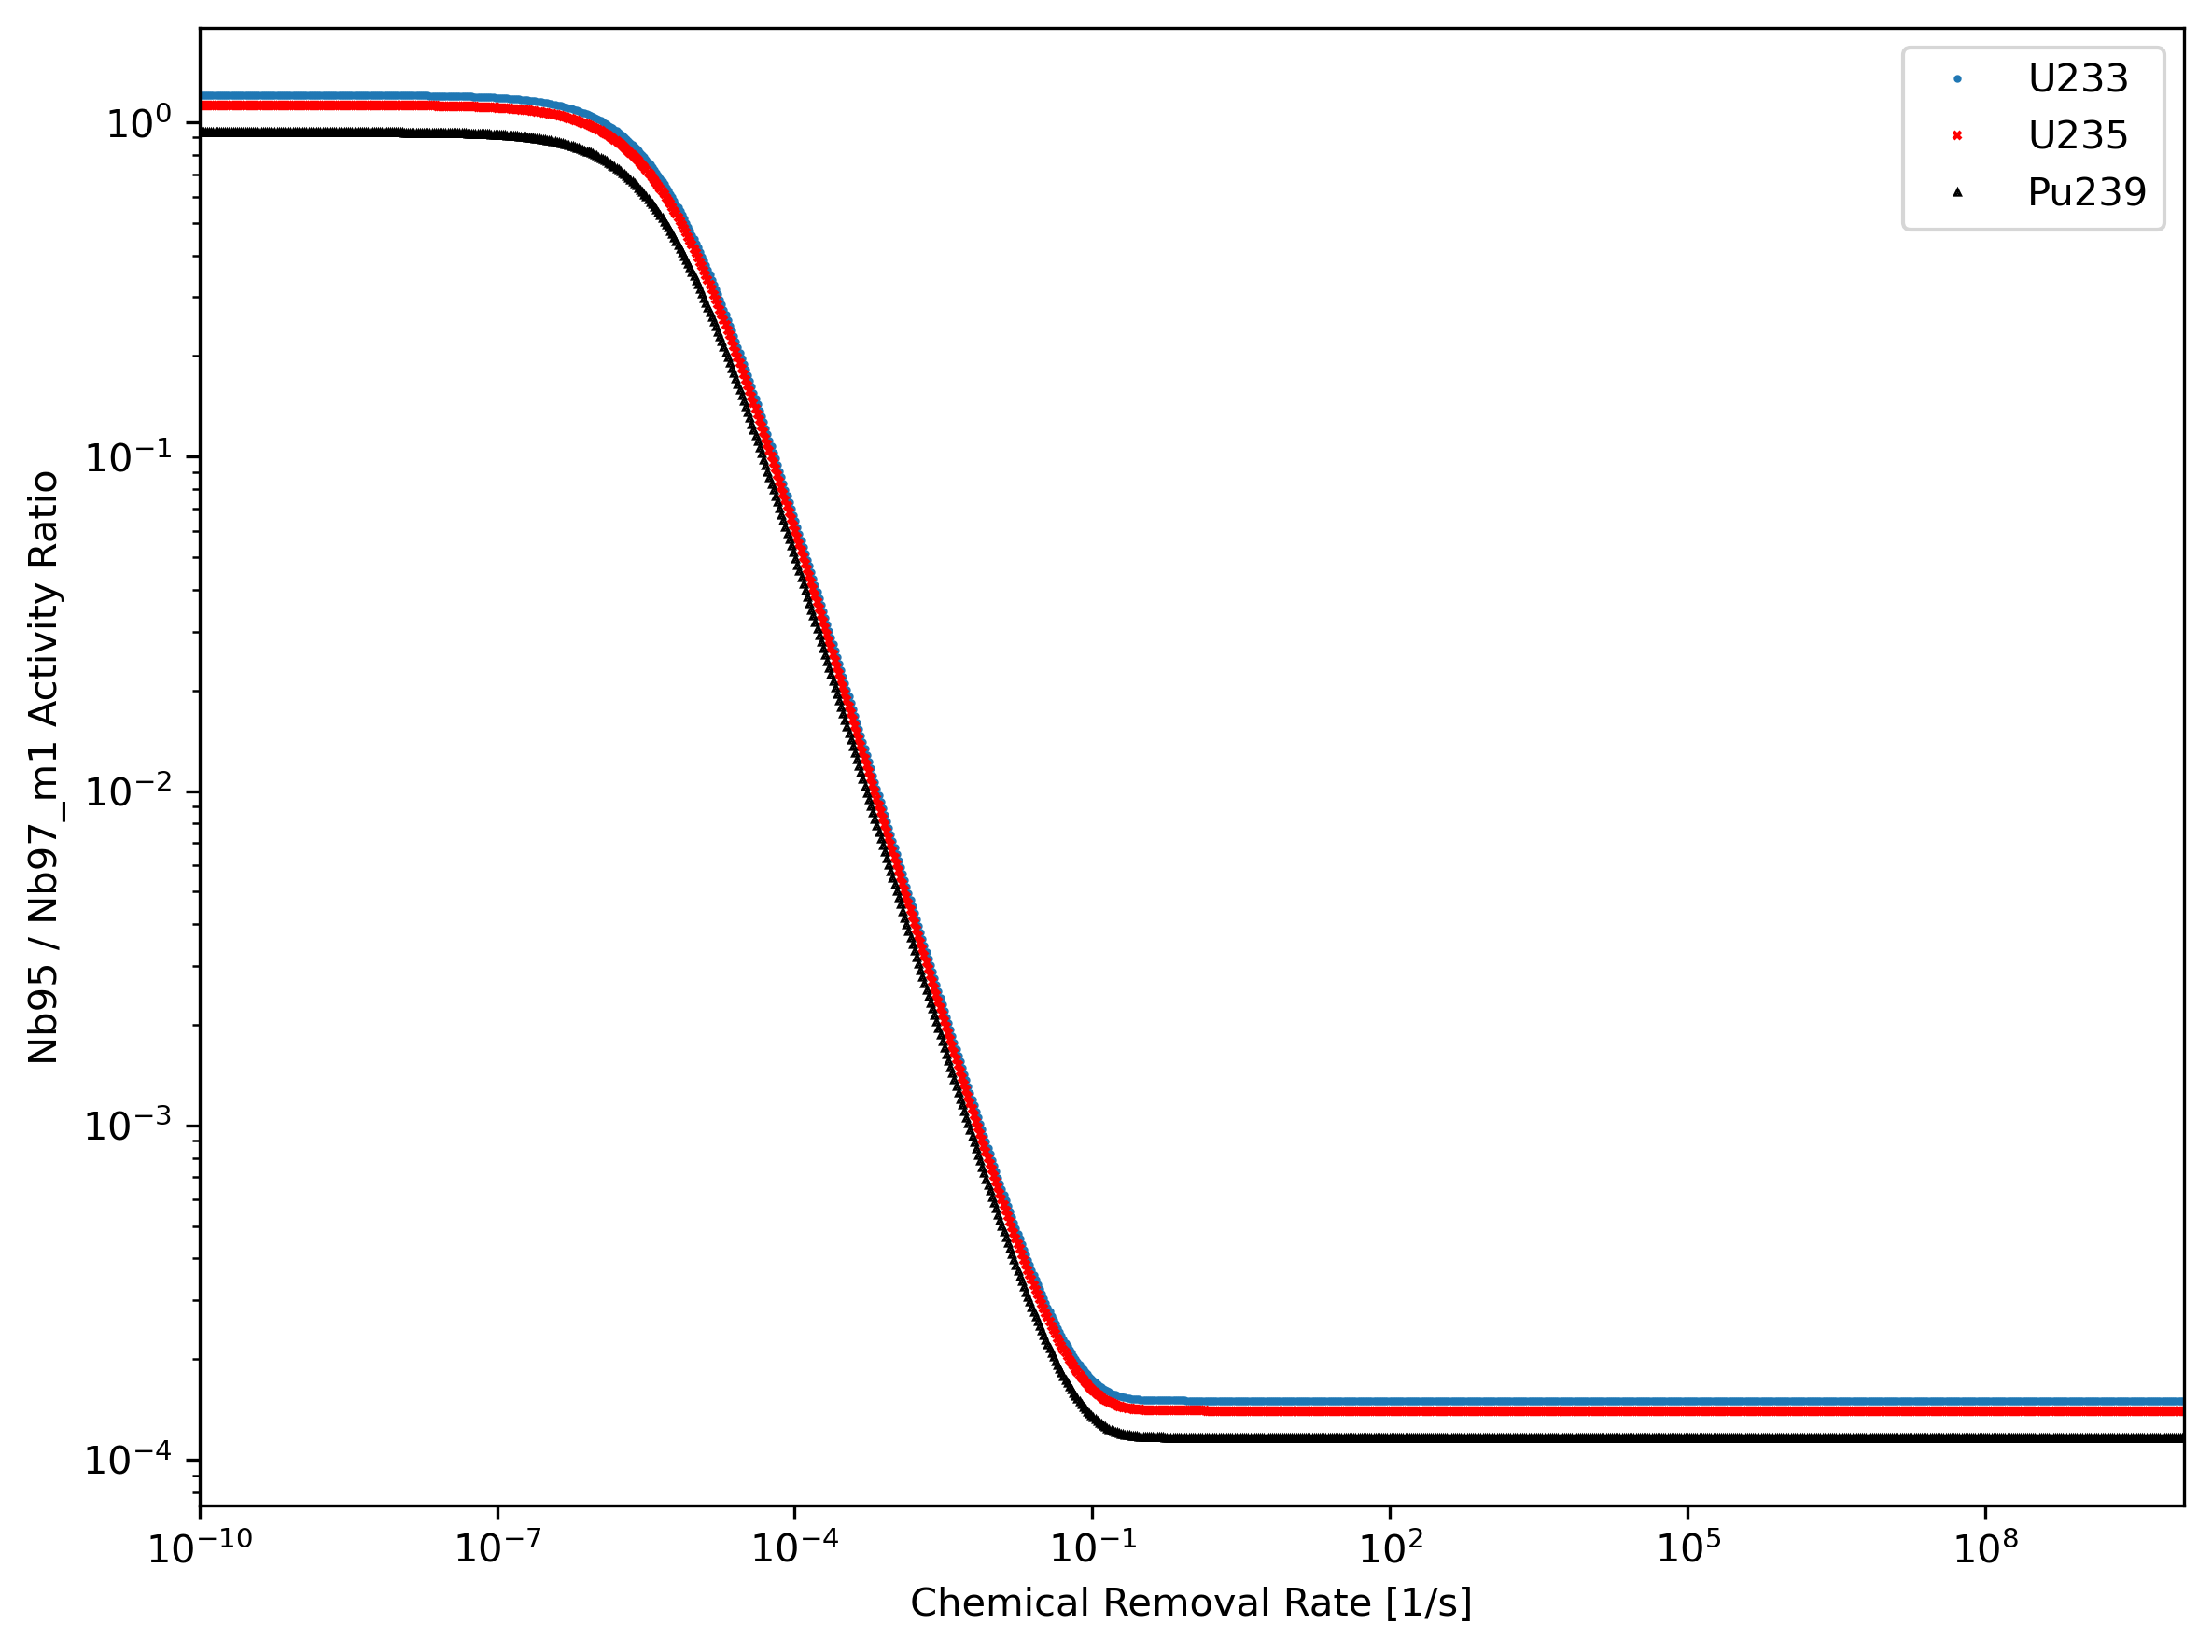

In [112]:
###
### Plotter for ratios of nuclides for one region
###

###
### Pick which nuclide to plot
### Saved nuclides: Nb95, Nb97, Nb97_m1
###

# Define the parameter you want to change
param1 = "nuc1"
param2 = "nuc2"
fissilename = "U235"

# Define the number of iterations
num_iter = 9

# Define the base name for the arrays
base_name1 = "Nb95"
base_name2 = "Nb97_m1"

# Define the custom name for the duplicated arrays
custom_name1 = f"a_{fissilename}_{param1}_"
custom_name2 = f"a_{fissilename}_{param2}_"

# Loop through the iterations and duplicate the arrays with custom names
for i in range(num_iter):
    # Define the original array name
    original_name1 = f"a_{fissilename}_{base_name1}_{i}"
    original_name2 = f"a_{fissilename}_{base_name2}_{i}"
        
    # Define the custom name for the current iteration
    current_name1 = f"{custom_name1}{i}"
    current_name2 = f"{custom_name2}{i}"
        
    # Duplicate the array with the custom name
    globals()[current_name1] = globals()[original_name1].copy()
    globals()[current_name2] = globals()[original_name2].copy()

globals()[f"x_{param1}"] = globals()[f"x_{base_name1}"].copy()

Nb95_765keV_intensity = 0.99808
Nb97_657keV_intensity = 0.9823
Nb97m_743keV_intensity = 0.979

custom_xmin = 10 ** power_min
custom_xmax = 10 ** power_max
# custom_xmin = 0
# custom_xmax = 8

# x_nuc1 = np.array(x_nuc1)/1E6

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6), dpi=300)
fig.set_facecolor("white")
plot_reg = 1
ax1.plot(x_nuc1, np.array(a_U233_nuc1_3)/np.array(a_U233_nuc2_3), '.', markersize=2)
ax1.plot(x_nuc1, np.array(a_U235_nuc1_3)/np.array(a_U235_nuc2_3), 'x', color='red', markersize=2)
ax1.plot(x_nuc1, np.array(a_Pu239_nuc1_3)/np.array(a_Pu239_nuc2_3), '^', color='black', markersize=1)
# ax1.set_title("Core Outlet")
ax1.set_xscale('log')
ax1.set_xlim(custom_xmin, custom_xmax)
ax1.set_yscale('log')
# ax1.set_ylim(1e1, 1E3)
# ax1.axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1.axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1.set_xlabel("Chemical Removal Rate [1/s]")
# ax1.set_xlabel("Reactor Power [MWth]")
ax1.set_ylabel(f"{base_name1} / {base_name2} Activity Ratio")
ax1.legend(['U233', 'U235', 'Pu239'], loc='best')

fig.tight_layout(rect=[0,0,1,1])
# plt.savefig(f'{base_name1}_{base_name2}_activity_ratio_report_table.png', dpi=150, format='png')

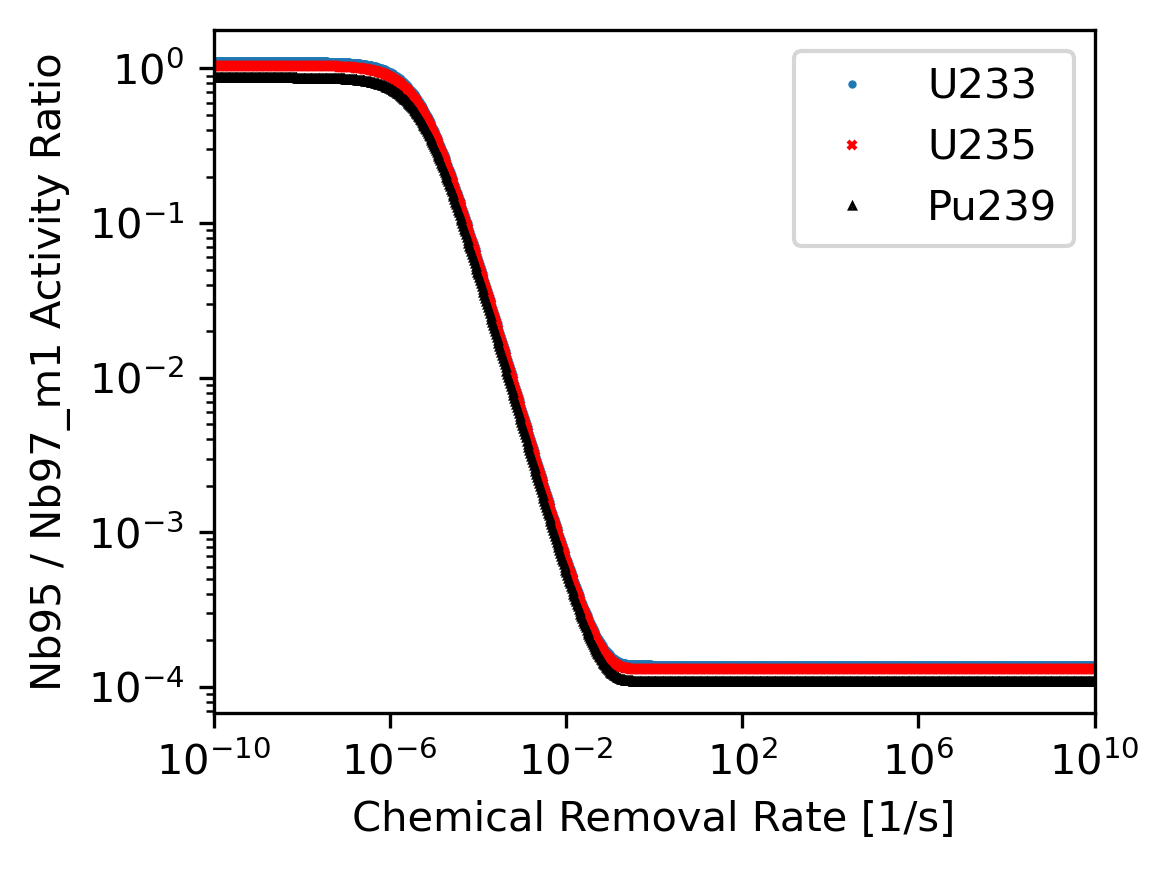

In [54]:
###
### Plotter for ratios of Nb nuclides for one region
###

###
### Pick which nuclide to plot
### Saved nuclides: Nb95, Nb97, Nb97_m1
###

Nb95_765keV_intensity = 0.99808
Nb97_657keV_intensity = 0.9823
Nb97m_743keV_intensity = 0.979

custom_xmin = 10 ** power_min
custom_xmax = 10 ** power_max
# custom_xmin = 0
# custom_xmax = 8

# x_nuc1 = np.array(x_nuc1)/1E6

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4,3), dpi=300)
fig.set_facecolor("white")
plot_reg = 1
ax1.plot(x_Nb95, np.array(a_U233_Nb95_0)/np.array(a_U233_Nb97_m1_0), '.', markersize=2)
ax1.plot(x_Nb95, np.array(a_U235_Nb95_0)/np.array(a_U235_Nb97_m1_0), 'x', color='red', markersize=2)
ax1.plot(x_Nb95, np.array(a_Pu239_Nb95_0)/np.array(a_Pu239_Nb97_m1_0), '^', color='black', markersize=1)
# ax1.set_title("Core Outlet")
ax1.set_xscale('log')
ax1.set_xlim(custom_xmin, custom_xmax)
ax1.set_yscale('log')
# ax1.set_ylim(1e-1, 1E1)
# ax1.axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1.axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1.set_xlabel("Chemical Removal Rate [1/s]")
# ax1.set_xlabel("Reactor Power [MWth]")
ax1.set_ylabel(f"{base_name1} / {base_name2} Activity Ratio")
ax1.legend(['U233', 'U235', 'Pu239'], loc='best')

fig.tight_layout(rect=[0,0,1,1])
# plt.savefig(f'{base_name1}_{base_name2}_activity_ratio_report_table.png', dpi=150, format='png')

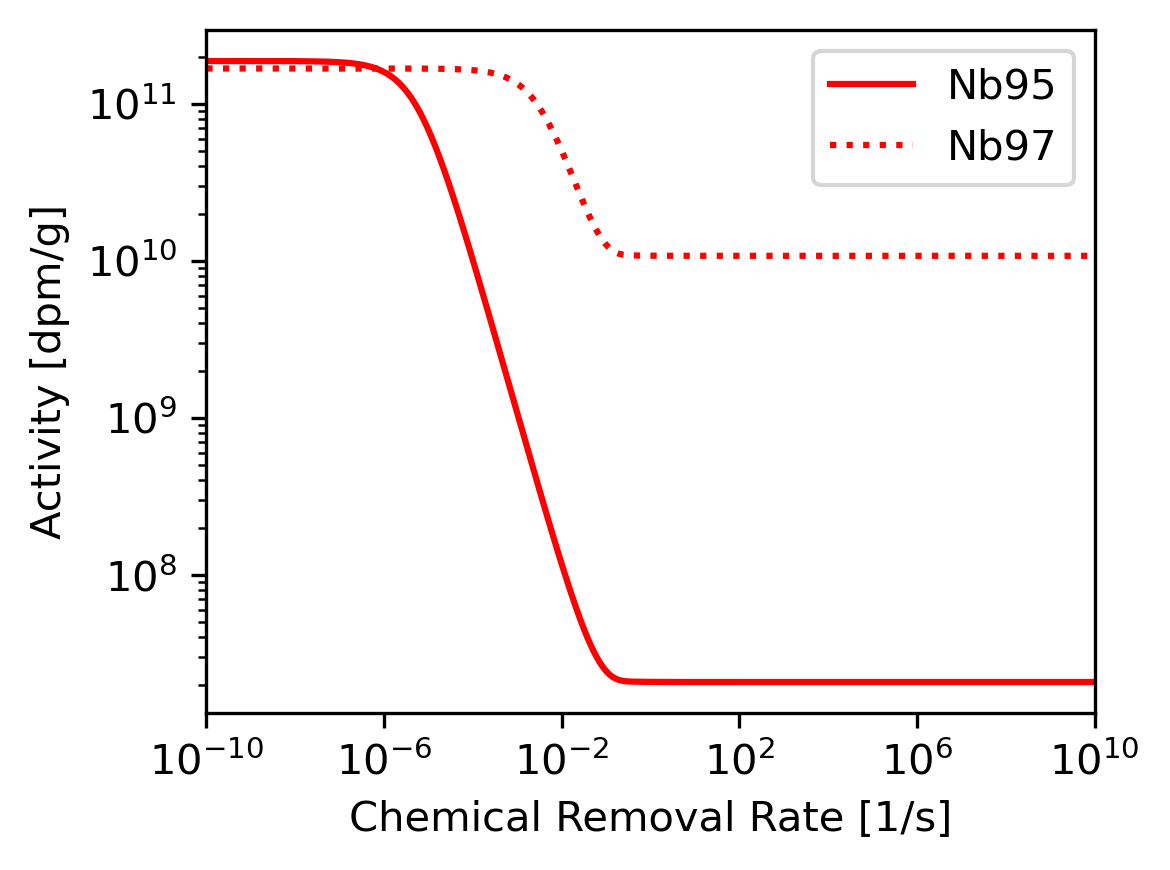

In [57]:
###
### Plotter for multiple nuclides for one region
###

###
### Pick which nuclide to plot
### Saved nuclides: Nb95, Nb97, Nb97_m1
###

# Define the parameter you want to change
param1 = "nuc1"
param2 = "nuc2"
fissilename = "U235"

# Define the number of iterations
num_iter = 9

# Define the base name for the arrays
base_name1 = "Nb95"
base_name2 = "Nb97"

# Define the custom name for the duplicated arrays
custom_name1 = f"a_{fissilename}_{param1}_"
custom_name2 = f"a_{fissilename}_{param2}_"

# Loop through the iterations and duplicate the arrays with custom names
for i in range(num_iter):
    # Define the original array name
    original_name1 = f"a_{fissilename}_{base_name1}_{i}"
    original_name2 = f"a_{fissilename}_{base_name2}_{i}"
        
    # Define the custom name for the current iteration
    current_name1 = f"{custom_name1}{i}"
    current_name2 = f"{custom_name2}{i}"
        
    # Duplicate the array with the custom name
    globals()[current_name1] = globals()[original_name1].copy()
    globals()[current_name2] = globals()[original_name2].copy()

globals()[f"x_{param1}"] = globals()[f"x_{base_name1}"].copy()

Nb95_765keV_intensity = 0.99808
Nb97_657keV_intensity = 0.9823
Nb97m_743keV_intensity = 0.979

custom_xmin = 10 ** power_min
custom_xmax = 10 ** power_max
# custom_xmin = 0
# custom_xmax = 8

# x_nuc1 = np.array(x_nuc1)/1E6

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4,3), dpi=300)
fig.set_facecolor("white")
plot_reg = 1
# ax1.plot(x_nuc1, np.array(a_U233_nuc1_4)/np.array(a_U233_nuc2_4), '.', markersize=2)
ax1.plot(x_nuc1, a_U235_nuc1_3, linestyle="solid", color='red')
ax1.plot(x_nuc1, a_U235_nuc2_3, linestyle="dotted", color='red')
# ax1.plot(x_nuc1, np.array(a_Pu239_nuc1_4)/np.array(a_Pu239_nuc2_4), '^', color='black', markersize=1)
# ax1.set_title("Core Outlet")
ax1.set_xscale('log')
ax1.set_xlim(custom_xmin, custom_xmax)
ax1.set_yscale('log')
# ax1.set_ylim(1e1, 1E3)
# ax1.axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1.axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1.set_xlabel("Chemical Removal Rate [1/s]")
# ax1.set_xlabel("Reactor Power [MWth]")
ax1.set_ylabel("Activity [dpm/g]")
ax1.legend(['Nb95', 'Nb97'], loc='best')

fig.tight_layout(rect=[0,0,1,1])
# plt.savefig(f'{base_name1}_{base_name2}_activities_report_table.png', dpi=150, format='png')

In [113]:
####
#### Save the above arrays into a df and csv
####

# Create a dictionary with the column names and arrays
data = {'x_nuc1': x_nuc1,
        'a_U233_nuc1_4': a_U233_nuc1_4,
        'a_U233_nuc2_4': a_U233_nuc2_4,
        'a_U235_nuc1_4': a_U235_nuc1_4,
        'a_U235_nuc2_4': a_U235_nuc2_4,
        'a_Pu239_nuc1_4': a_Pu239_nuc1_4,
        'a_Pu239_nuc2_4': a_Pu239_nuc2_4}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)
df_reactorpower = df # df_removalrate
# Save the DataFrame to a CSV file
# df.to_csv('95_to_97m_ratio_removalrate.csv', index=False)

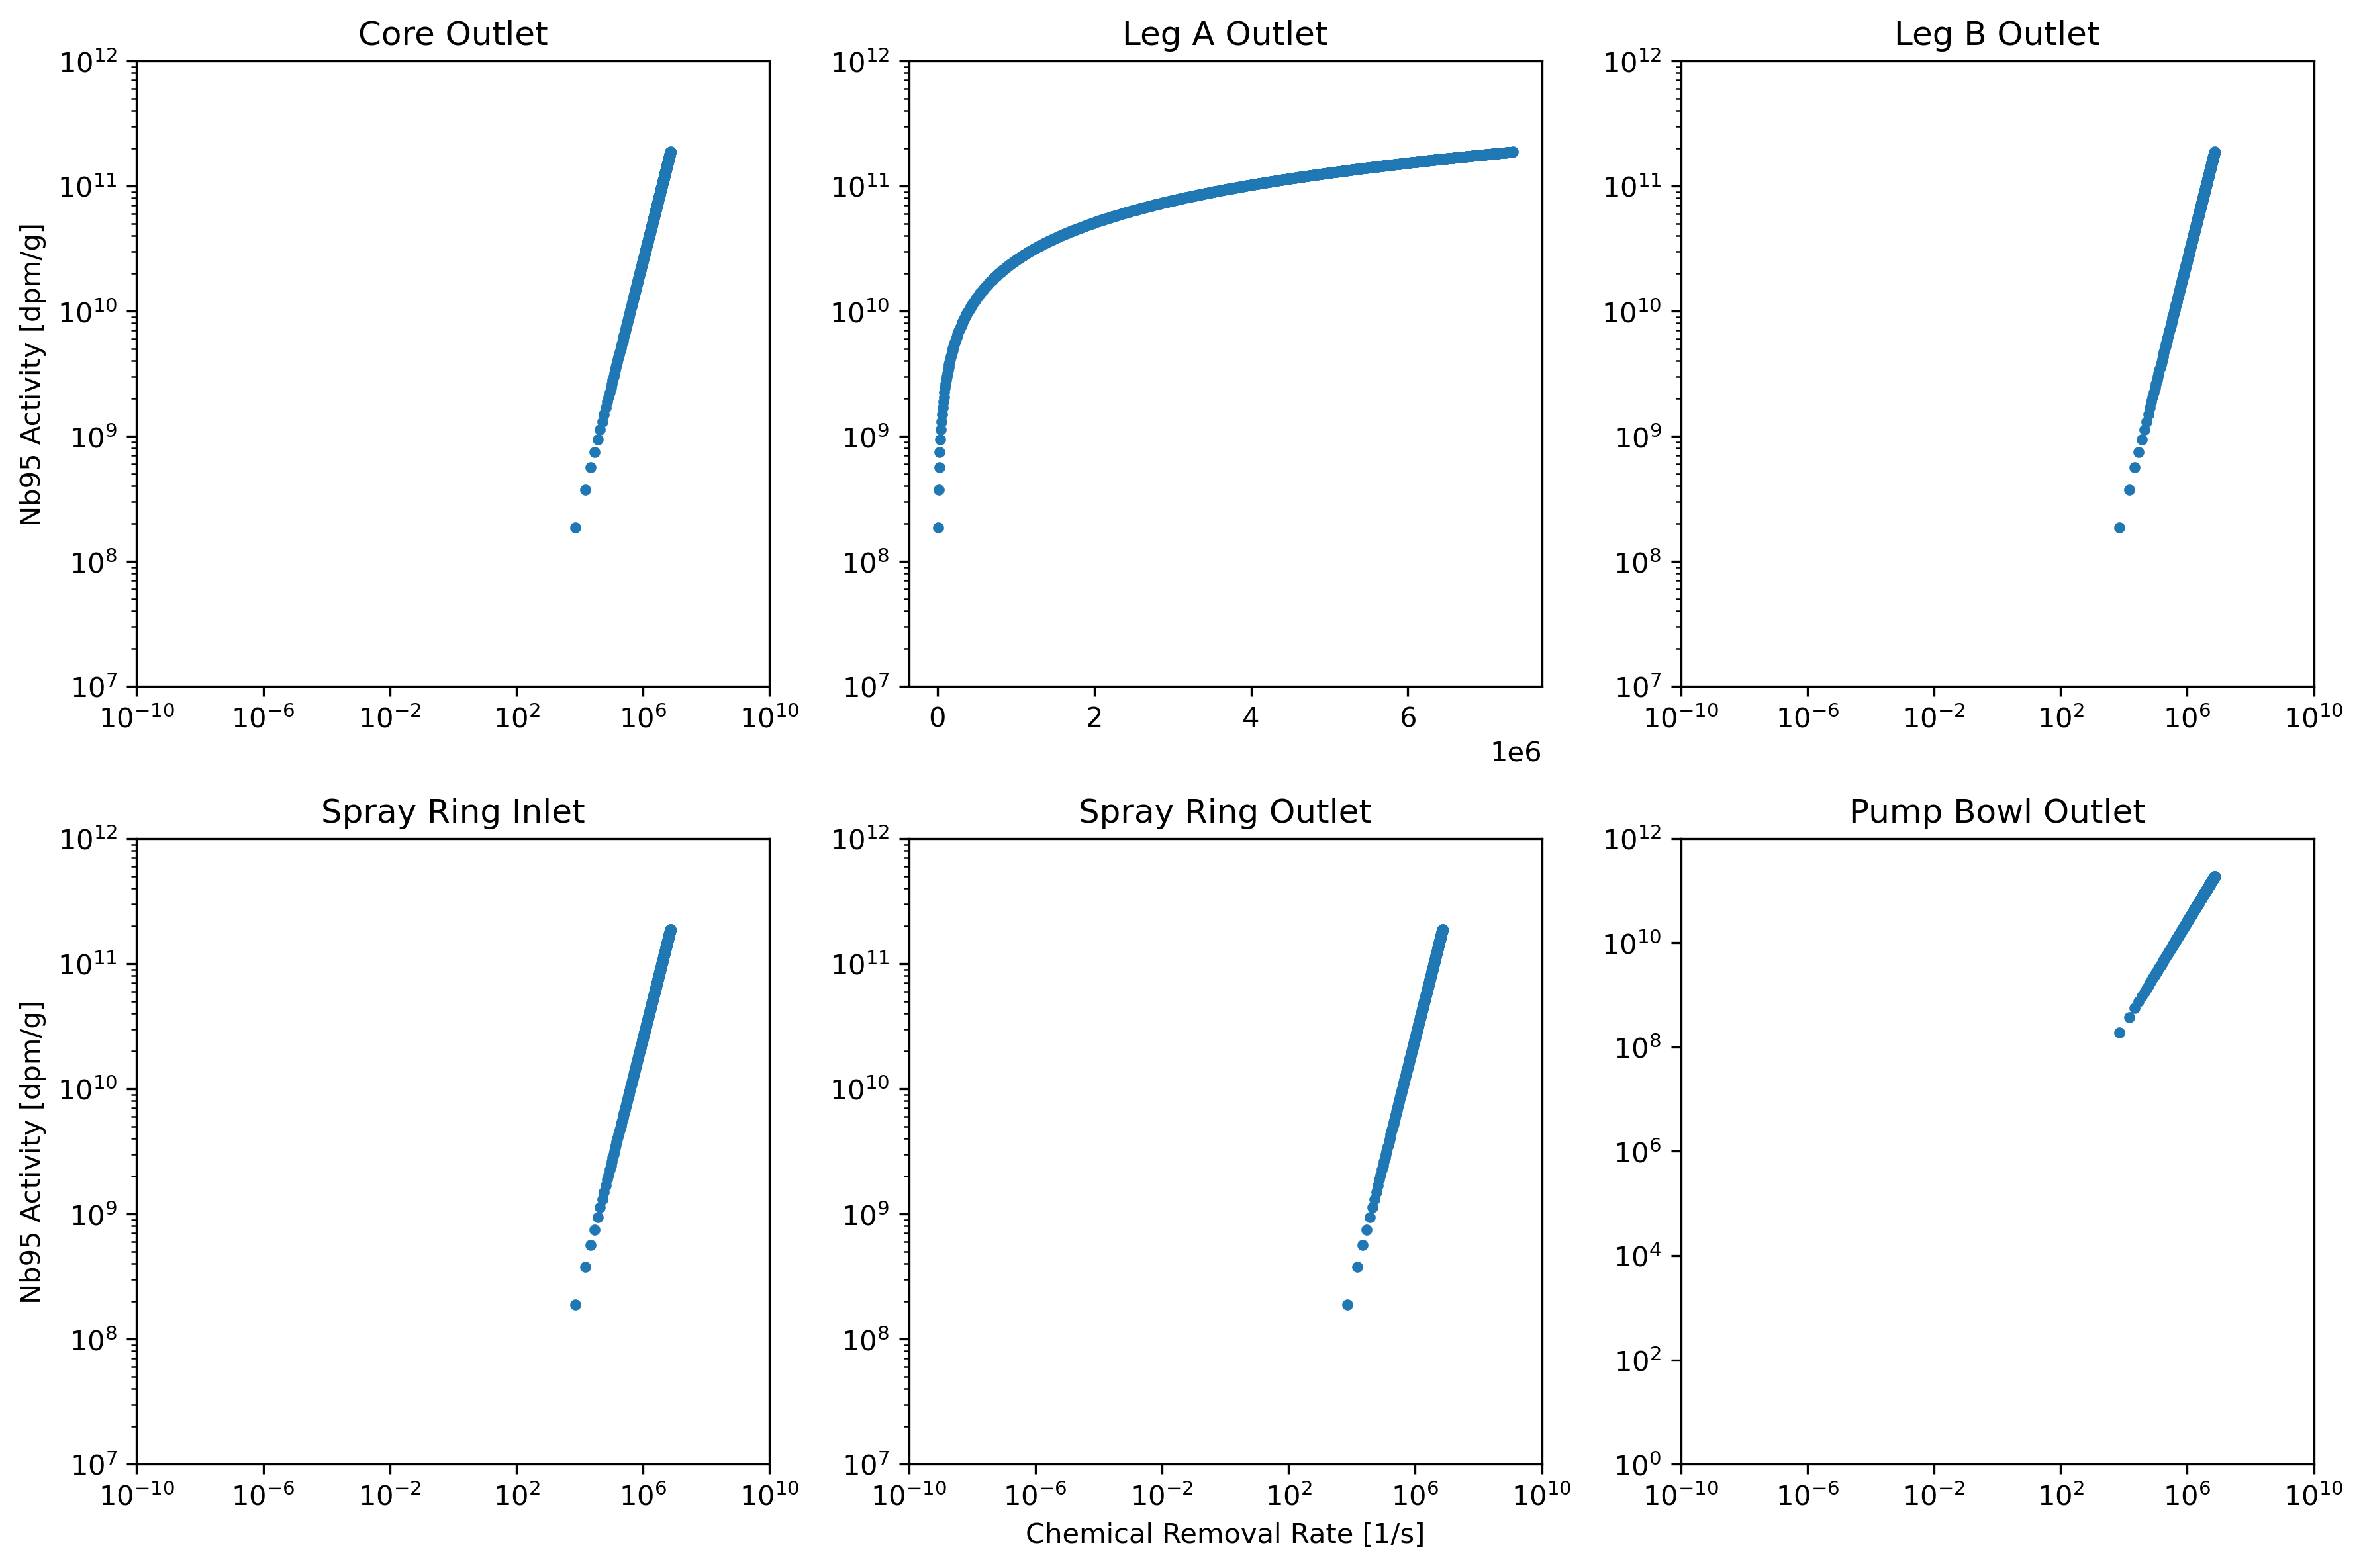

In [84]:
###
### Plotter for the one nuclide across different regions
###

###
### Pick which nuclide to plot
### Saved nuclides: Nb95, Nb97, Nb97_m1
###

# Define the parameter you want to change
param = "nuc"

# Define the number of regions of the MSR
num_iter = 9

# Define the base name for the arrays
base_name = "Nb95"

# Define the custom name for the duplicated arrays
custom_name = f"a_{param}_"

# Loop through the iterations and duplicate the arrays with custom names
for i in range(num_iter):
    # Define the original array name
    original_name = f"a_{base_name}_{i}"
    
    # Define the custom name for the current iteration
    current_name = f"{custom_name}{i}"
    
    # Duplicate the array with the custom name
    globals()[current_name] = globals()[original_name].copy()

globals()[f"x_{param}"] = globals()[f"x_{base_name}"].copy()

Nb95_765keV_intensity = 0.99808
Nb97_657keV_intensity = 0.9823
Nb97m_743keV_intensity = 0.979

fig, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(12,8), dpi=300)
fig.set_facecolor("white")

ax1[0, 0].plot(x_nuc, a_nuc_0, '.')
ax1[0, 0].set_title("Core Outlet")
ax1[0, 0].set_xscale('log')
ax1[0, 0].set_xlim(10 ** power_min, 10 ** power_max)
ax1[0, 0].set_yscale('log')
ax1[0, 0].set_ylim(1e7, 1E12)
# ax1[0, 0].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[0, 0].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[0, 1].plot(x_nuc, a_nuc_1, '.')
ax1[0, 1].set_title("Leg A Outlet")
ax1[0, 1].set_xscale('log')
ax1[0, 1].set_xlim(10 ** power_min, 10 ** power_max)
ax1[0, 1].set_yscale('log')
ax1[0, 1].set_ylim(1e7, 1E12)
# ax1[0, 1].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[0, 1].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[0, 2].plot(x_nuc, a_nuc_3, '.')
ax1[0, 2].set_title("Leg B Outlet")
ax1[0, 2].set_xscale('log')
ax1[0, 2].set_xlim(10 ** power_min, 10 ** power_max)
ax1[0, 2].set_yscale('log')
ax1[0, 2].set_ylim(1e7, 1E12)
# ax1[0, 2].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[0, 2].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[1, 0].plot(x_nuc, a_nuc_4, '.')
ax1[1, 0].set_title("Spray Ring Inlet")
ax1[1, 0].set_xscale('log')
ax1[1, 0].set_xlim(10 ** power_min, 10 ** power_max)
ax1[1, 0].set_yscale('log')
ax1[1, 0].set_ylim(1e7, 1E12)
# ax1[1, 0].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[1, 0].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[1, 1].plot(x_nuc, a_nuc_5, '.')
ax1[1, 1].set_title("Spray Ring Outlet")
ax1[1, 1].set_xscale('log')
ax1[1, 1].set_xlim(10 ** power_min, 10 ** power_max)
ax1[1, 1].set_yscale('log')
ax1[1, 1].set_ylim(1e7, 1E12)
# ax1[1, 1].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[1, 1].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[1, 2].plot(x_nuc, a_nuc_6, '.')
ax1[1, 2].set_title("Pump Bowl Outlet")
ax1[1, 2].set_xscale('log')
ax1[1, 2].set_xlim(10 ** power_min, 10 ** power_max)
ax1[1, 2].set_yscale('log')
ax1[1, 2].set_ylim(1e0, 1E12)
# ax1[1, 2].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[1, 2].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[1, 1].set_xlabel("Chemical Removal Rate [1/s]")
ax1[0, 0].set_ylabel(f"{base_name} Activity [dpm/g]")
ax1[1, 0].set_ylabel(f"{base_name} Activity [dpm/g]")

fig.tight_layout(rect=[0,0,1,1])
plt.savefig(f'{base_name}_activity_across_regions.png', dpi=150, format='png')

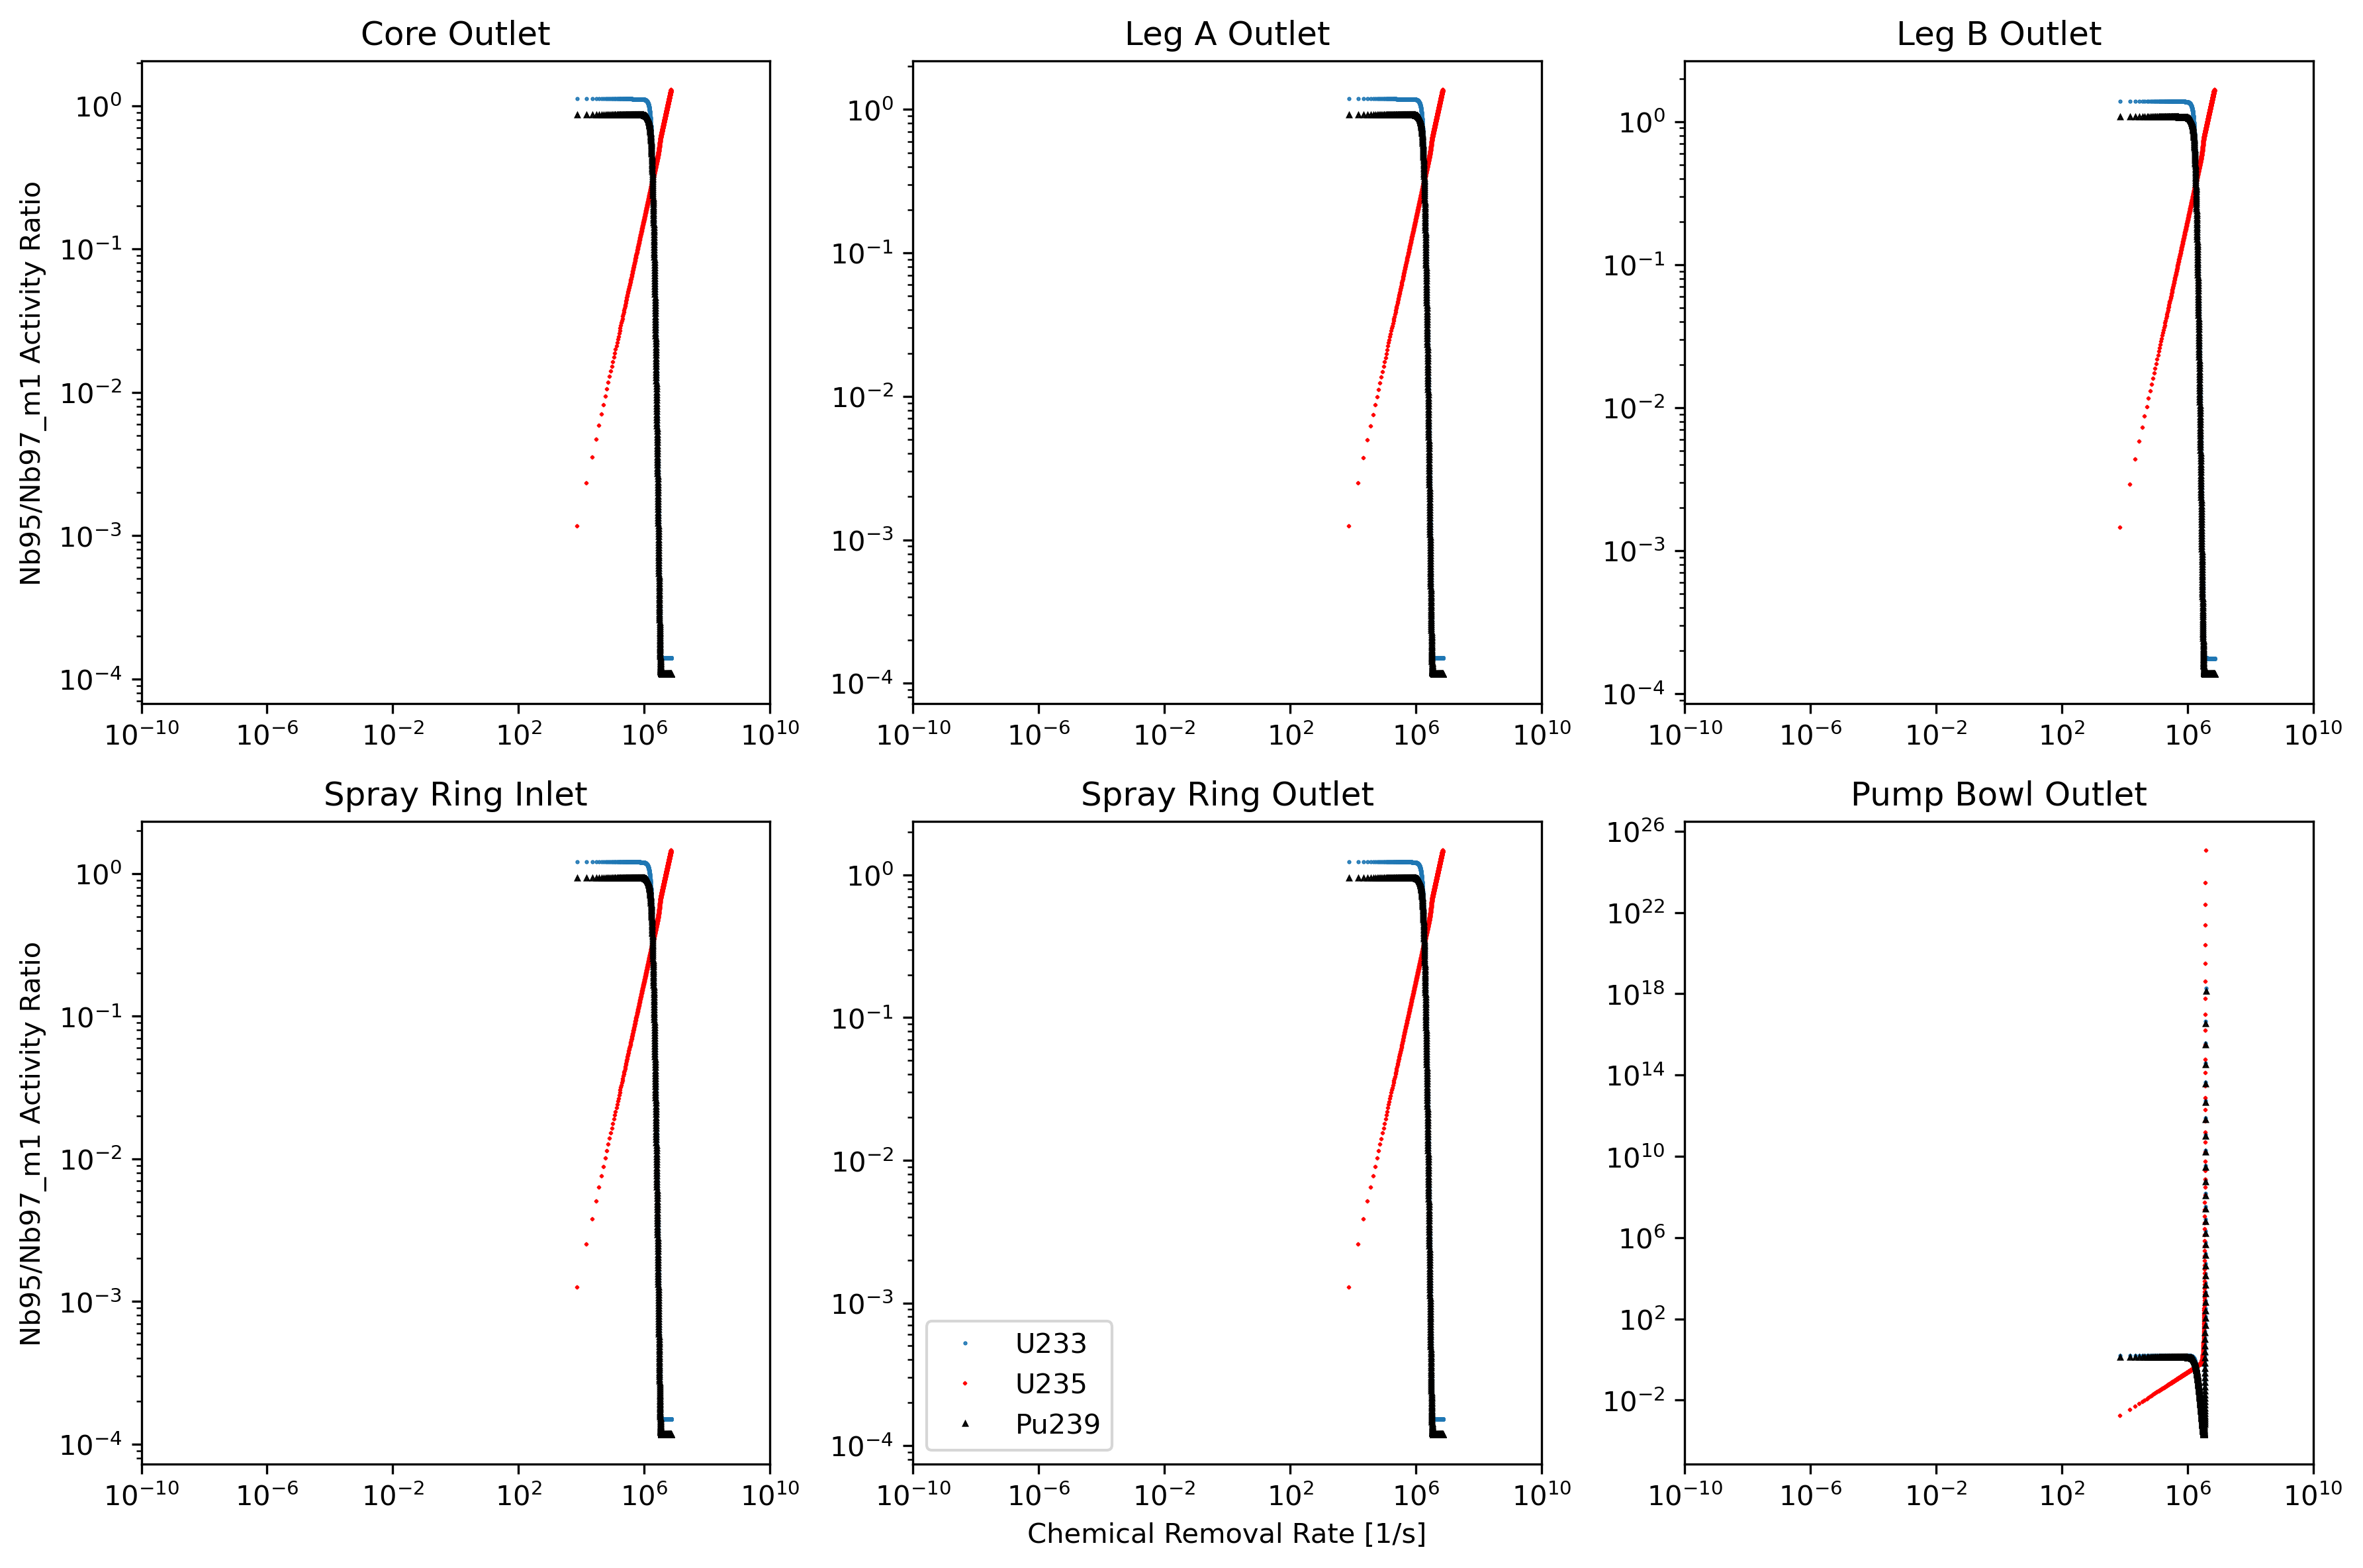

In [88]:
###
### Plotter for ratios of nuclides across different regions
###

###
### Pick which nuclide to plot
### Saved nuclides: Nb95, Nb97, Nb97_m1
###

# Define the parameter you want to change
param1 = "nuc1"
param2 = "nuc2"

# Define the number of iterations
num_iter = 9

# Define the base name for the arrays
base_name1 = "Nb95"
base_name2 = "Nb97_m1"

# Define the custom name for the duplicated arrays
custom_name1 = f"a235_{param1}_"
custom_name2 = f"a235_{param2}_"

# Loop through the iterations and duplicate the arrays with custom names
for i in range(num_iter):
    # Define the original array name
    original_name1 = f"a_{base_name1}_{i}"
    original_name2 = f"a_{base_name2}_{i}"
        
    # Define the custom name for the current iteration
    current_name1 = f"{custom_name1}{i}"
    current_name2 = f"{custom_name2}{i}"
        
    # Duplicate the array with the custom name
    globals()[current_name1] = globals()[original_name1].copy()
    globals()[current_name2] = globals()[original_name2].copy()

globals()[f"x_{param1}"] = globals()[f"x_{base_name1}"].copy()

Nb95_765keV_intensity = 0.99808
Nb97_657keV_intensity = 0.9823
Nb97m_743keV_intensity = 0.979

fig, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(12,8), dpi=300)
fig.set_facecolor("white")

custom_xmin = 10 ** power_min
custom_xmax = 10 ** power_max
# custom_xmin = 1E-4
# custom_xmax = 1E-3

ax1[0, 0].plot(x_nuc1, np.array(a233_nuc1_0)/np.array(a233_nuc2_0), '.', markersize=1)
ax1[0, 0].plot(x_nuc1, np.array(a235_nuc1_0)/np.array(a235_nuc2_0), 'x', color='red', markersize=1)
ax1[0, 0].plot(x_nuc1, np.array(a239_nuc1_0)/np.array(a239_nuc2_0), '^', color='black', markersize=1)
ax1[0, 0].set_title("Core Outlet")
ax1[0, 0].set_xscale('log')
ax1[0, 0].set_xlim(custom_xmin, custom_xmax)
ax1[0, 0].set_yscale('log')
# ax1[0, 0].set_ylim(1e0, 1E4)
# ax1[0, 0].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[0, 0].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[0, 1].plot(x_nuc1, np.array(a233_nuc1_1)/np.array(a233_nuc2_1), '.', markersize=1)
ax1[0, 1].plot(x_nuc1, np.array(a235_nuc1_1)/np.array(a235_nuc2_1), 'x', color='red', markersize=1)
ax1[0, 1].plot(x_nuc1, np.array(a239_nuc1_1)/np.array(a239_nuc2_1), '^', color='black', markersize=1)
ax1[0, 1].set_title("Leg A Outlet")
ax1[0, 1].set_xscale('log')
ax1[0, 1].set_xlim(custom_xmin, custom_xmax)
ax1[0, 1].set_yscale('log')
# ax1[0, 1].set_ylim(1e0, 1E4)
# ax1[0, 1].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[0, 1].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[0, 2].plot(x_nuc1, np.array(a233_nuc1_3)/np.array(a233_nuc2_3), '.', markersize=1)
ax1[0, 2].plot(x_nuc1, np.array(a235_nuc1_3)/np.array(a235_nuc2_3), 'x', color='red', markersize=1)
ax1[0, 2].plot(x_nuc1, np.array(a239_nuc1_3)/np.array(a239_nuc2_3), '^', color='black', markersize=1)
ax1[0, 2].set_title("Leg B Outlet")
ax1[0, 2].set_xscale('log')
ax1[0, 2].set_xlim(custom_xmin, custom_xmax)
ax1[0, 2].set_yscale('log')
# ax1[0, 2].set_ylim(1e0, 1E4)
# ax1[0, 2].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[0, 2].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[1, 0].plot(x_nuc1, np.array(a233_nuc1_4)/np.array(a233_nuc2_4), '.', markersize=1)
ax1[1, 0].plot(x_nuc1, np.array(a235_nuc1_4)/np.array(a235_nuc2_4), 'x', color='red', markersize=1)
ax1[1, 0].plot(x_nuc1, np.array(a239_nuc1_4)/np.array(a239_nuc2_4), '^', color='black', markersize=1)
ax1[1, 0].set_title("Spray Ring Inlet")
ax1[1, 0].set_xscale('log')
ax1[1, 0].set_xlim(custom_xmin, custom_xmax)
ax1[1, 0].set_yscale('log')
# ax1[1, 0].set_ylim(1e0, 1E4)
# ax1[1, 0].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[1, 0].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[1, 1].plot(x_nuc1, np.array(a233_nuc1_5)/np.array(a233_nuc2_5), '.', markersize=1)
ax1[1, 1].plot(x_nuc1, np.array(a235_nuc1_5)/np.array(a235_nuc2_5), 'x', color='red', markersize=1)
ax1[1, 1].plot(x_nuc1, np.array(a239_nuc1_5)/np.array(a239_nuc2_5), '^', color='black', markersize=1)
ax1[1, 1].set_title("Spray Ring Outlet")
ax1[1, 1].set_xscale('log')
ax1[1, 1].set_xlim(custom_xmin, custom_xmax)
ax1[1, 1].set_yscale('log')
# ax1[1, 1].set_ylim(1e0, 1E4)
# ax1[1, 1].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[1, 1].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')
ax1[1, 1].legend(['U233', 'U235', 'Pu239'], loc='best')

ax1[1, 2].plot(x_nuc1, np.array(a233_nuc1_6)/np.array(a233_nuc2_6), '.', markersize=1)
ax1[1, 2].plot(x_nuc1, np.array(a235_nuc1_6)/np.array(a235_nuc2_6), 'x', color='red', markersize=1)
ax1[1, 2].plot(x_nuc1, np.array(a239_nuc1_6)/np.array(a239_nuc2_6), '^', color='black', markersize=1)
ax1[1, 2].set_title("Pump Bowl Outlet")
ax1[1, 2].set_xscale('log')
ax1[1, 2].set_xlim(custom_xmin, custom_xmax)
ax1[1, 2].set_yscale('log')
# ax1[1, 2].set_ylim(1e0, 1E4)
# ax1[1, 2].axhline(y=cum_anal_dpmg[4], linestyle='--', color='green', marker='>')
# ax1[1, 2].axhline(y=anal_dpmg[4], linestyle=':', color='red', marker='<')

ax1[1, 1].set_xlabel("Chemical Removal Rate [1/s]")
ax1[0, 0].set_ylabel(f"{base_name1}/{base_name2} Activity Ratio")
ax1[1, 0].set_ylabel(f"{base_name1}/{base_name2} Activity Ratio")

fig.tight_layout(rect=[0,0,1,1])
# plt.savefig(f'{base_name1}-{base_name2}_across_regions_eachfissile.png', dpi=150, format='png')